In [4]:
import pandas as pd
from datetime import datetime, date, timedelta
from requests import post
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import sys
sys.path.insert(1, '../src/')
from basebot import BaseBot

In [6]:
bot = BaseBot("testbot")

df = bot.getData(ticker = "IWDA.AS", start_date = datetime(2010,1,1), technical_indicators=["all"])
df = bot.getTrend(df)
df.head()

,ticker,open,high,low,close,volume,adj_close,volume_adi,volume_obv,volume_cmf,...,momentum_kama,others_dr,others_dlr,others_cr,SMA_3,SMA_10,SMA_50,SMA_100,SMA_200,signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-12,IWDA.AS,42.455002,42.674999,42.455002,42.575001,53831,42.575001,4893.896985,53831.0,0.090912,...,42.575001,-25.658017,0.433580,0.434522,42.725,42.7965,44.072,0,45.01955,1.0
2017-09-13,IWDA.AS,42.540001,42.759998,42.445000,42.759998,73915,42.759998,78808.896985,127746.0,0.616919,...,42.649766,0.434522,0.433580,0.434522,42.725,42.7965,44.072,0,45.01955,1.0
2017-09-14,IWDA.AS,42.730000,42.860001,42.689999,42.840000,19521,42.840000,93736.668981,147267.0,0.636508,...,42.724116,0.187095,0.186920,0.622430,42.725,42.7965,44.072,0,45.01955,1.0
2017-09-15,IWDA.AS,42.674999,42.689999,42.470001,42.575001,25357,42.575001,92584.257942,121910.0,0.536335,...,42.662290,-0.618579,-0.620500,0.364061,42.725,42.7965,44.072,0,45.01955,1.0
2017-09-18,IWDA.AS,42.779999,42.860001,42.669998,42.730000,44301,42.730000,76263.117764,166211.0,0.351564,...,42.689158,0.364061,0.363399,0.364061,42.715,42.7965,44.072,0,45.01955,1.0


In [7]:
df["signal"].value_counts()

 1.0    862
-1.0    435
Name: signal, dtype: int64

-1 represents sell (downtrend), 1 buy (uptrend), 0 is not yet decided

## simulate best possible scenario

(following signal)

<AxesSubplot:xlabel='timestamp'>

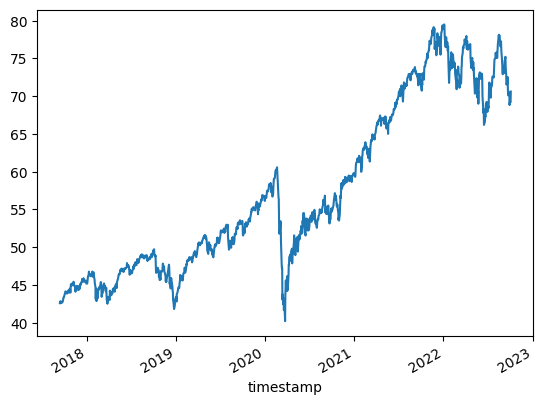

In [8]:
df["adj_close"].plot()

In [9]:
## calculate timespan
days = (df.index[-1] - df.index[0]).days
print("index takes %d days" % days)

index takes 1848 days


In [10]:
## baseline
startMoney = 10000
COMMISSION = 0.00025
nrStocks = startMoney / df.iloc[0]["adj_close"]
print("you would have bought {} stocks".format(nrStocks))
baselineWin = df.iloc[-1]["adj_close"] * nrStocks - startMoney
print("just holding would have given you %.2f$" % baselineWin)
baselineWinPerMonth = baselineWin / days * 30
print("or %.2f$ per month" % baselineWinPerMonth)

you would have bought 234.87961998358358 stocks
just holding would have given you 6582.50$
or 106.86$ per month


following the signal would have given you 24914.74$
or 404.46$ per month


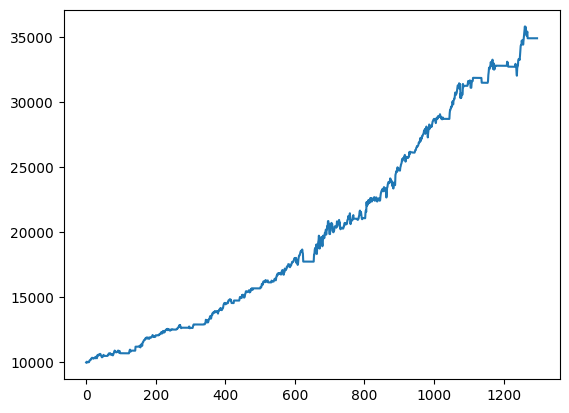

In [11]:
## next check if we follow signal what the best scenario would have been
money = startMoney
nrStocks = 0
bestPortfolio = []
for i in range(len(df)):
    if df.iloc[i]["signal"] == 1 and money > 0 and nrStocks == 0:
        amount = money / df.iloc[i]["adj_close"] * .99
        cost = amount * df.iloc[i]["adj_close"] * (1 + COMMISSION)
        money -= cost
        nrStocks += amount
    elif df.iloc[i]["signal"] == -1 and nrStocks > 0:
        money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
        nrStocks = 0
    bestPortfolio.append(money + nrStocks * df.iloc[i]["adj_close"])
# last day sell nrStocks
money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
nrStocks = 0

win = money - startMoney
print("following the signal would have given you %.2f$" % win)
winPerMonth = win / days * 30
print("or %.2f$ per month" % winPerMonth)
plt.plot(bestPortfolio)

## find correlations

In [12]:
df.corr()["signal"]

open      -0.012703
high      -0.017628
low       -0.002791
close     -0.007943
volume    -0.189934
             ...   
SMA_10    -0.050470
SMA_50    -0.134352
SMA_100         NaN
SMA_200   -0.155830
signal     1.000000
Name: signal, Length: 98, dtype: float64

In [13]:
## try to get some observations with decision tree
from sklearn import tree
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(  df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0), df["signal"], test_size=0.2)
clf = tree.DecisionTreeClassifier()
clf.fit(x_train, y_train)
scr = clf.score(x_test, y_test)
print("decision tree scores: ", scr)
pred = clf.predict(df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0))
# tree.plot_tree(clf)

decision tree scores:  0.8769230769230769


In [14]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None,
                        feature_names=x_train.columns,  
                        class_names=["sell", "buy"],
                        filled=True, rounded=True,
                        special_characters=True) 
graph = graphviz.Source(dot_data) 
# graph 

## simulate one run with training data

the decision tree with lookback 0 would have given you 18469.84$
or +36.48% per year
or 299.84$ per month


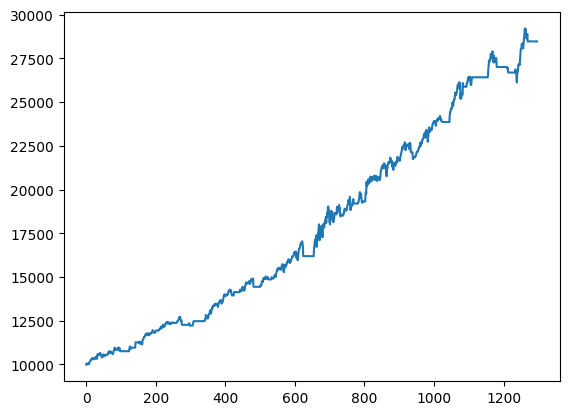

In [15]:



bestLookback = -1
bestLookbackWin = -9999
bestLookbackPortfolio = []
for lookback in [0]: # range(0, 10):
    money = startMoney
    nrStocks = 0
    portfolio = []
    for i in range(lookback, len(df)):
        # prednow = np.median(pred[i-lookback:i])
        prednow = pred[i]
        if prednow == 1 and nrStocks == 0 and money > 10:
            # buy
            howmany = money / df.iloc[i]["adj_close"] * .99
            cost = howmany * df.iloc[i]["adj_close"] * (1 + COMMISSION)
            money -= cost
            nrStocks += howmany
        elif prednow == -1 and nrStocks > 0:
            money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
            nrStocks = 0
        portfolio.append(money + nrStocks * df.iloc[i]["adj_close"])
    # last day sell
    money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
    win = money - startMoney
    if win > bestLookbackWin:
        bestLookback = lookback
        bestLookbackWin = win
        bestLookbackPortfolio = portfolio

print("the decision tree with lookback %d would have given you %.2f$" % (bestLookback, bestLookbackWin))
winPct = bestLookbackWin / startMoney * 100
winPctYear = winPct / days * 365
print("or +%.2f%% per year" % winPctYear)
winPerMonth = bestLookbackWin / days * 30
print("or %.2f$ per month" % winPerMonth)
plt.plot(bestLookbackPortfolio)
# lookback of 1
# the decision tree would have given you 19937.82$
# or 323.67$ per month

## try the same with xgb

In [16]:
# xgb doesnt like -1
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

In [17]:
import xgboost as xgb
from sklearn import metrics


clf = xgb.XGBClassifier(n_jobs = -1)
clf.fit(x_train, y_train)
# print(clf)
predicted_y = clf.predict(x_test)


In [18]:
print(metrics.classification_report(y_test, predicted_y))
print(metrics.confusion_matrix(y_test, predicted_y))



              precision    recall  f1-score   support

         0.0       0.84      0.83      0.83        92
         1.0       0.91      0.91      0.91       168

    accuracy                           0.88       260
   macro avg       0.87      0.87      0.87       260
weighted avg       0.88      0.88      0.88       260

[[ 76  16]
 [ 15 153]]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

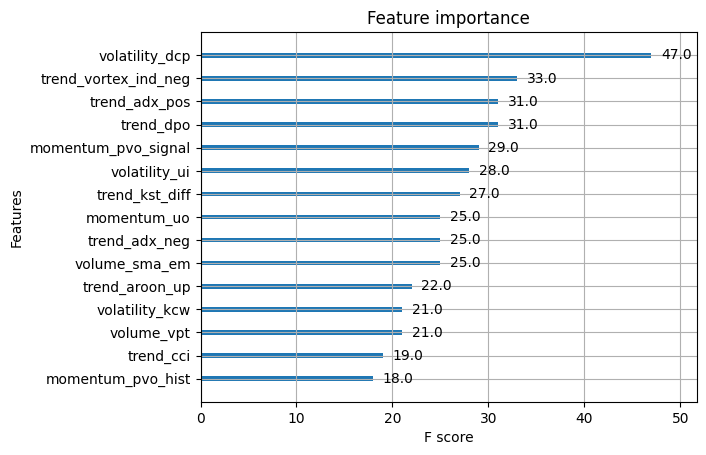

In [19]:
xgb.plot_importance(clf, max_num_features=15)

In [20]:
preds = clf.predict(df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0))

/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


the XGB with lookback 3 would have given you 6510.10$
or +12.86% per year
or 105.68$ per month


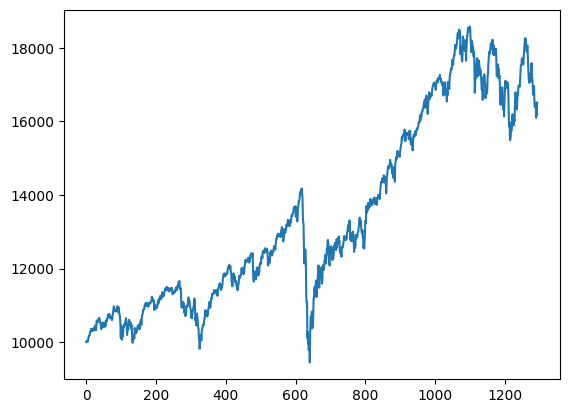

In [21]:
## do the same dance as with tree


bestLookback = -1
bestLookbackWin = -9999
bestLookbackPortfolio = []
for lookback in range(0, 10):
    money = startMoney
    nrStocks = 0
    portfolio = []
    for i in range(lookback, len(df)):
        prednow = np.median(preds[i-lookback:i])
        # prednow = preds[i]
        if prednow == 1 and nrStocks == 0 and money > 10:
            # buy
            howmany = money / df.iloc[i]["adj_close"] * .99
            cost = howmany * df.iloc[i]["adj_close"] * (1 + COMMISSION)
            money -= cost
            nrStocks += howmany
        elif prednow == -1 and nrStocks > 0:
            money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
            nrStocks = 0
        portfolio.append(money + nrStocks * df.iloc[i]["adj_close"])
    # last day sell
    money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
    win = money - startMoney
    if win > bestLookbackWin:
        bestLookback = lookback
        bestLookbackWin = win
        bestLookbackPortfolio = portfolio

print("the XGB with lookback %d would have given you %.2f$" % (bestLookback, bestLookbackWin))
winPct = bestLookbackWin / startMoney * 100
winPctYear = winPct / days * 365
print("or +%.2f%% per year" % winPctYear)
winPerMonth = bestLookbackWin / days * 30
print("or %.2f$ per month" % winPerMonth)
plt.plot(bestLookbackPortfolio)
## tree
# the decision tree with lookback 0 would have given you 19227.17$
# or +37.98% per year
# or 312.13$ per month
## XGB - actually not too nice
# the XGB with lookback 3 would have given you 6510.10$
# or +12.86% per year
# or 105.68$ per month


## lgbm classifer

In [22]:
import lightgbm as ltb
clf = ltb.LGBMClassifier()
clf.fit(x_train, y_train)
predicted_y = clf.predict(x_test)
print(metrics.classification_report(y_test, predicted_y))
print(metrics.confusion_matrix(y_test, predicted_y))

              precision    recall  f1-score   support

         0.0       0.83      0.80      0.82        92
         1.0       0.89      0.91      0.90       168

    accuracy                           0.87       260
   macro avg       0.86      0.86      0.86       260
weighted avg       0.87      0.87      0.87       260

[[ 74  18]
 [ 15 153]]


In [23]:
preds = clf.predict(df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0))

/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


the lightgbm with lookback 3 would have given you 6510.10$
or +12.86% per year
or 105.68$ per month


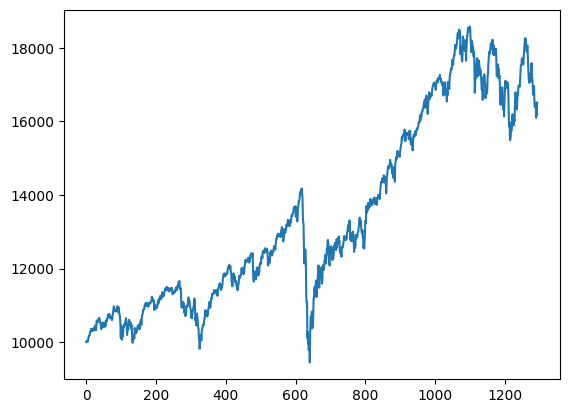

In [24]:
## do the same dance as with xgb


bestLookback = -1
bestLookbackWin = -9999
bestLookbackPortfolio = []
for lookback in range(0, 10):
    money = startMoney
    nrStocks = 0
    portfolio = []
    for i in range(lookback, len(df)):
        prednow = np.median(preds[i-lookback:i])
        # prednow = preds[i]
        if prednow == 1 and nrStocks == 0 and money > 10:
            # buy
            howmany = money / df.iloc[i]["adj_close"] * .99
            cost = howmany * df.iloc[i]["adj_close"] * (1 + COMMISSION)
            money -= cost
            nrStocks += howmany
        elif prednow == -1 and nrStocks > 0:
            money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
            nrStocks = 0
        portfolio.append(money + nrStocks * df.iloc[i]["adj_close"])
    # last day sell
    money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
    win = money - startMoney
    if win > bestLookbackWin:
        bestLookback = lookback
        bestLookbackWin = win
        bestLookbackPortfolio = portfolio

print("the lightgbm with lookback %d would have given you %.2f$" % (bestLookback, bestLookbackWin))
winPct = bestLookbackWin / startMoney * 100
winPctYear = winPct / days * 365
print("or +%.2f%% per year" % winPctYear)
winPerMonth = bestLookbackWin / days * 30
print("or %.2f$ per month" % winPerMonth)
plt.plot(bestLookbackPortfolio)
## tree
# the decision tree with lookback 0 would have given you 19227.17$
# or +37.98% per year
# or 312.13$ per month
## XGB - actually not too nice
# the xgb with lookback 3 would have given you 3497.44$
# or +6.91% per year
# or 56.78$ per month
## lightgbm 
# the lightgbm with lookback 3 would have given you 6510.10$
# or +12.86% per year
# or 105.68$ per month

## linear SVC with pipeline

In [25]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(),LinearSVC())

clf.fit(x_train, y_train)

predicted_y = clf.predict(x_test)
print(metrics.classification_report(y_test, predicted_y))
print(metrics.confusion_matrix(y_test, predicted_y))

              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84        92
         1.0       0.90      0.93      0.91       168

    accuracy                           0.89       260
   macro avg       0.88      0.87      0.88       260
weighted avg       0.89      0.89      0.89       260

[[ 75  17]
 [ 12 156]]


/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [26]:
## hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = {'SVC__C':np.arange(0.01,100,10)}

SVCpipe = Pipeline([('scale', StandardScaler()),
                ('SVC',LinearSVC())])
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=4,return_train_score=True,n_jobs = -1)
linearSVC.fit(x_train,y_train)
print(linearSVC.best_params_)
bestlinearSVC = linearSVC.best_estimator_

predicted_y = bestlinearSVC.predict(x_test)
print(metrics.classification_report(y_test, predicted_y))
print(metrics.confusion_matrix(y_test, predicted_y))

/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: Convergenc

{'SVC__C': 0.01}
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84        92
         1.0       0.90      0.93      0.92       168

    accuracy                           0.89       260
   macro avg       0.89      0.87      0.88       260
weighted avg       0.89      0.89      0.89       260

[[ 75  17]
 [ 11 157]]


/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: Convergenc

# now something interesting, what if we use the same for another stock :o?

In [27]:
clf = tree.DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier()

In [28]:
df = bot.getData(ticker = "AAPL", start_date = datetime(2010,1,1), technical_indicators=["all"])
df = bot.getTrend(df)

preds = clf.predict(df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0))
print(metrics.classification_report(df["signal"], preds))
print(metrics.confusion_matrix(df["signal"], preds))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       454
         0.0       0.00      0.00      0.00         0
         1.0       0.83      0.89      0.86       822

    accuracy                           0.57      1276
   macro avg       0.28      0.30      0.29      1276
weighted avg       0.53      0.57      0.55      1276

[[  0 302 152]
 [  0   0   0]
 [  0  92 730]]


/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jguese/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jguese/miniconda3/lib/pytho

if we use it for another stock performance is not too good!
but well that shouldn't surprise us.

next try to train on a ton of different data and see if we can create a generalized predictor

In [29]:
bigDf = []
for ticker in ["CWEG.L", "IWDA.AS", "EEM", "AAPL", "MSFT", "GOOG", "TSLA", 'AMD', 'AMZN', 'DG', "ETH-USD"]:
    print("geddin stock: " + ticker)
    df = bot.getData(ticker = ticker, start_date = datetime(2010,1,1), technical_indicators=["all"])
    df = bot.getTrend(df)
    bigDf.append(df)
    
bigDf = pd.concat(bigDf)
bigDf.head()

geddin stock: CWEG.L
geddin stock: IWDA.AS
geddin stock: EEM
geddin stock: AAPL
geddin stock: MSFT
geddin stock: GOOG
geddin stock: TSLA
geddin stock: AMD
geddin stock: AMZN
geddin stock: DG
geddin stock: ETH-USD


,ticker,open,high,low,close,volume,adj_close,volume_adi,volume_obv,volume_cmf,...,momentum_kama,others_dr,others_dlr,others_cr,SMA_3,SMA_10,SMA_50,SMA_100,SMA_200,signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-03-09,CWEG.L,22440.0,22440.0,22430.0,22470.0,1400,22470.0,9800.0,1400.0,7.000000,...,22470.000000,-4.433549,-0.591421,-0.589675,22313.333333,25491.75,21117.01,0,0.0,1.0
2018-03-21,CWEG.L,21870.0,21870.0,21870.0,22337.5,1400,22337.5,9800.0,-34.0,3.500000,...,22409.540207,-0.589675,-0.591421,-0.589675,23607.500000,25041.25,21117.01,0,0.0,1.0
2018-03-27,CWEG.L,22090.0,22090.0,22090.0,22132.5,34,22132.5,9800.0,-34.0,3.458010,...,22281.687834,-0.917739,-0.921976,-1.502003,22313.333333,25491.75,21117.01,0,0.0,1.0
2018-05-15,CWEG.L,26400.0,26400.0,26400.0,26352.5,619,26352.5,9800.0,585.0,2.838112,...,22828.240240,19.066983,17.451603,17.278594,23607.500000,25041.25,21117.01,0,0.0,1.0
2018-05-29,CWEG.L,25345.0,25345.0,25345.0,25532.5,619,25532.5,9800.0,-34.0,2.406680,...,23200.201165,-3.111659,-3.161100,13.629283,24672.500000,25491.75,21117.01,0,0.0,1.0


In [30]:
x_train, x_test, y_train, y_test = train_test_split(  df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0), df["signal"], test_size=0.1, shuffle=True)
clf = tree.DecisionTreeClassifier()
clf.fit(x_train, y_train)
scr = clf.score(x_test, y_test)
print("decision tree scores: ", scr)
pred = clf.predict(df.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0))

decision tree scores:  0.8833333333333333


In [31]:
dot_data = tree.export_graphviz(clf, out_file=None,
                        feature_names=x_train.columns,  
                        class_names=["sell", "buy"],
                        filled=True, rounded=True,
                        special_characters=True) 
graph = graphviz.Source(dot_data) 
# graph

In [32]:
## simulate


bestLookback = -1
bestLookbackWin = -9999
bestLookbackPortfolio = dict()
for lookback in range(0, 10):
    money = startMoney
    nrStocks = 0
    portfolio = dict()
    for i in range(lookback, len(df)):
        prednow = np.median(preds[i-lookback:i])
        # if we switched stock sell the old and continue with new
        if df.iloc[i]["ticker"] != df.iloc[i-1]["ticker"]:
            money += nrStocks * df.iloc[i-1]["adj_close"] * (1 - COMMISSION)
            nrStocks = 0
            portfolio[df.iloc[i]["ticker"]] = []
        # prednow = preds[i]
        if prednow == 1 and nrStocks == 0 and money > 10:
            # buy
            howmany = money / df.iloc[i]["adj_close"] * .99
            cost = howmany * df.iloc[i]["adj_close"] * (1 + COMMISSION)
            money -= cost
            nrStocks += howmany
        elif prednow == -1 and nrStocks > 0:
            money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
            nrStocks = 0
        try:
            portfolio[df.iloc[i]["ticker"]] = portfolio[df.iloc[i]["ticker"]].append(money + nrStocks * df.iloc[i]["adj_close"])
        except:
            # idk
            pass
    # last day sell
    money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
    win = money - startMoney
    if win > bestLookbackWin:
        bestLookback = lookback
        bestLookbackWin = win
        bestLookbackPortfolio = portfolio

print("the lightgbm with lookback %d would have given you %.2f$" % (bestLookback, bestLookbackWin))
winPct = bestLookbackWin / startMoney * 100
days = (df.index[-1] - df.index[0]).days
winPctYear = winPct / days * 365
print("or +%.2f%% per year" % winPctYear)
winPerMonth = bestLookbackWin / days * 30
print("or %.2f$ per month" % winPerMonth)
for ticker,portfolio in bestLookbackPortfolio:
    plt.title(ticker)
    plt.plot(bestLookbackPortfolio)
    plt.show()
## tree
# the decision tree with lookback 0 would have given you 19227.17$
# or +37.98% per year
# or 312.13$ per month
## XGB - actually not too nice
# the xgb with lookback 3 would have given you 3497.44$
# or +6.91% per year
# or 56.78$ per month
## lightgbm 
# the lightgbm with lookback 3 would have given you 6510.10$
# or +12.86% per year
# or 105.68$ per month

/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


the lightgbm with lookback 1 would have given you 35155.43$
or +71.69% per year
or 589.20$ per month


## next try to "dumb" down decision tree until we find a good mix between reducing accuracy and complexity



In [116]:
## limit to one stock?
bigDf = bot.getData(ticker = "AAPL", start_date = datetime(2010,1,1), technical_indicators=["all"])
bigDf = bot.getTrend(bigDf)

In [117]:
# for this use the whole data
X, Y = bigDf.drop(["signal", "ticker"], axis = 1).fillna(method="bfill").fillna(0), bigDf["signal"]


In [118]:
# free decision tree has: 0.89
for depth in [100,20,15,10,5,3,2]:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf.fit(X, Y)
    scr = clf.score(X, Y)
    print("decision tree score with a depth of %d: " % depth, scr)

decision tree score with a depth of 100:  1.0
decision tree score with a depth of 20:  1.0
decision tree score with a depth of 15:  1.0
decision tree score with a depth of 10:  0.9992163009404389
decision tree score with a depth of 5:  0.9655172413793104
decision tree score with a depth of 3:  0.9420062695924765
decision tree score with a depth of 2:  0.9028213166144201


In [124]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(X, Y)
scr = clf.score(X, Y)
print("decision tree score with a depth of 5: ", scr)

decision tree score with a depth of 5:  0.9655172413793104


In [125]:
# then see how many features we can reduce
for nrFeatures in [10,9,8,7,6,5,4,3,2]:
    clf = tree.DecisionTreeClassifier(max_depth=5, max_leaf_nodes = nrFeatures)
    clf.fit(X, Y)
    scr = clf.score(X, Y)
    print("decision tree score with nr features of %d: " % nrFeatures, scr)

decision tree score with nr features of 10:  0.9498432601880877
decision tree score with nr features of 9:  0.9474921630094044
decision tree score with nr features of 8:  0.945141065830721
decision tree score with nr features of 7:  0.9396551724137931
decision tree score with nr features of 6:  0.9365203761755486
decision tree score with nr features of 5:  0.9231974921630094
decision tree score with nr features of 4:  0.9028213166144201
decision tree score with nr features of 3:  0.9028213166144201
decision tree score with nr features of 2:  0.9028213166144201


In [133]:
# it seems like 6 features looks good with 0.887555228276

clf = tree.DecisionTreeClassifier(max_depth=5, max_leaf_nodes = 8)
clf.fit(X, Y)
scr = clf.score(X,Y)
print("decision tree score with depth 4 and max_leaf_nodes 6: " , scr)

decision tree score with depth 4 and max_leaf_nodes 6:  0.945141065830721


the ideal depth seems to be 4. it reaches accuracy of 0.88

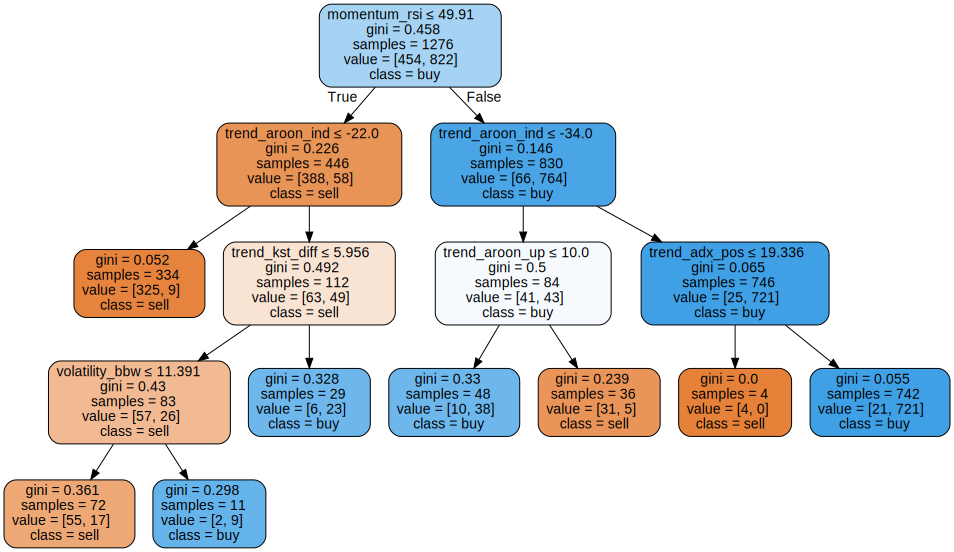

In [134]:
dot_data = tree.export_graphviz(clf, out_file=None,
                        feature_names=x_train.columns,  
                        class_names=["sell", "buy"],
                        filled=True, rounded=True,
                        special_characters=True) 
graph = graphviz.Source(dot_data) 
graph

## next try to "translate" the decision tree to if/else conditions

In [136]:
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_71 <= 49.91
|   |--- feature_66 <= -22.00
|   |   |--- class: -1.0
|   |--- feature_66 >  -22.00
|   |   |--- feature_52 <= 5.96
|   |   |   |--- feature_19 <= 11.39
|   |   |   |   |--- class: -1.0
|   |   |   |--- feature_19 >  11.39
|   |   |   |   |--- class: 1.0
|   |   |--- feature_52 >  5.96
|   |   |   |--- class: 1.0
|--- feature_71 >  49.91
|   |--- feature_66 <= -34.00
|   |   |--- feature_64 <= 10.00
|   |   |   |--- class: 1.0
|   |   |--- feature_64 >  10.00
|   |   |   |--- class: -1.0
|   |--- feature_66 >  -34.00
|   |   |--- feature_59 <= 19.34
|   |   |   |--- class: -1.0
|   |   |--- feature_59 >  19.34
|   |   |   |--- class: 1.0



In [137]:
from sklearn.tree import _tree

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [138]:
get_rules(clf, x_train.columns, ["sell", "buy"])

['if (momentum_rsi > 49.91) and (trend_aroon_ind > -34.0) and (trend_adx_pos > 19.336) then class: buy (proba: 97.17%) # | based on 742 samples',
 'if (momentum_rsi <= 49.91) and (trend_aroon_ind <= -22.0) then class: sell (proba: 97.31%) # | based on 334 samples',
 'if (momentum_rsi <= 49.91) and (trend_aroon_ind > -22.0) and (trend_kst_diff <= 5.956) and (volatility_bbw <= 11.391) then class: sell (proba: 76.39%) # | based on 72 samples',
 'if (momentum_rsi > 49.91) and (trend_aroon_ind <= -34.0) and (trend_aroon_up <= 10.0) then class: buy (proba: 79.17%) # | based on 48 samples',
 'if (momentum_rsi > 49.91) and (trend_aroon_ind <= -34.0) and (trend_aroon_up > 10.0) then class: sell (proba: 86.11%) # | based on 36 samples',
 'if (momentum_rsi <= 49.91) and (trend_aroon_ind > -22.0) and (trend_kst_diff > 5.956) then class: buy (proba: 79.31%) # | based on 29 samples',
 'if (momentum_rsi <= 49.91) and (trend_aroon_ind > -22.0) and (trend_kst_diff <= 5.956) and (volatility_bbw > 11.391

In [139]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    print("def getDecision(dfrow):")

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if dfrow['{}'] <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if dfrow['{}'] > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, np.argmax(tree_.value[node][0])))

    recurse(0, 1)
tree_to_code(clf, x_train.columns)

def getDecision(dfrow):
    if dfrow['momentum_rsi'] <= 49.91:
        if dfrow['trend_aroon_ind'] <= -22.0:
            return 0
        else:  # if dfrow['trend_aroon_ind'] > -22.0
            if dfrow['trend_kst_diff'] <= 5.96:
                if dfrow['volatility_bbw'] <= 11.39:
                    return 0
                else:  # if dfrow['volatility_bbw'] > 11.39
                    return 1
            else:  # if dfrow['trend_kst_diff'] > 5.96
                return 1
    else:  # if dfrow['momentum_rsi'] > 49.91
        if dfrow['trend_aroon_ind'] <= -34.0:
            if dfrow['trend_aroon_up'] <= 10.0:
                return 1
            else:  # if dfrow['trend_aroon_up'] > 10.0
                return 0
        else:  # if dfrow['trend_aroon_ind'] > -34.0
            if dfrow['trend_adx_pos'] <= 19.34:
                return 0
            else:  # if dfrow['trend_adx_pos'] > 19.34
                return 1


In [140]:
def getDecision(dfrow):
    if dfrow['momentum_rsi'] <= 49.91:
        if dfrow['trend_aroon_ind'] <= -22.0:
            return 0
        else:  # if dfrow['trend_aroon_ind'] > -22.0
            if dfrow['trend_kst_diff'] <= 5.96:
                if dfrow['volatility_bbw'] <= 11.39:
                    return 0
                else:  # if dfrow['volatility_bbw'] > 11.39
                    return 1
            else:  # if dfrow['trend_kst_diff'] > 5.96
                return 1
    else:  # if dfrow['momentum_rsi'] > 49.91
        if dfrow['trend_aroon_ind'] <= -34.0:
            if dfrow['trend_aroon_up'] <= 10.0:
                return 1
            else:  # if dfrow['trend_aroon_up'] > 10.0
                return 0
        else:  # if dfrow['trend_aroon_ind'] > -34.0
            if dfrow['trend_adx_pos'] <= 19.34:
                return 0
            else:  # if dfrow['trend_adx_pos'] > 19.34
                return 1

# final simulation

In [113]:
## to simulate earnings we need to grab one ticker only again
# df = bot.getData(ticker = "IWDA.AS", start_date = datetime(2010,1,1), technical_indicators=["all"])
# df = bot.getTrend(df)

In [141]:
preds = []
for i in range(len(df)):
    dec = getDecision(df.iloc[i])
    if dec == 0:
        dec = -1
    preds.append(dec)
print(np.unique(preds, return_counts=True))
print(metrics.classification_report(df["signal"], preds))
print(metrics.confusion_matrix(df["signal"], preds))

(array([-1,  1]), array([431, 866]))
              precision    recall  f1-score   support

        -1.0       0.83      0.82      0.82       435
         1.0       0.91      0.91      0.91       862

    accuracy                           0.88      1297
   macro avg       0.87      0.87      0.87      1297
weighted avg       0.88      0.88      0.88      1297

[[357  78]
 [ 74 788]]


/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jguese/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


the tuned getDecision decision tree with lookback 4 would have given you 4914.88$
or +9.71% per year
or 79.79$ per month


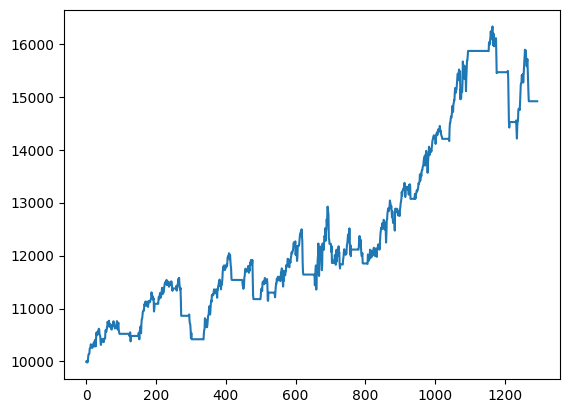

In [142]:
## last test on data


bestLookback = -1
bestLookbackWin = -9999
bestLookbackPortfolio = []
for lookback in range(0, 10):
    money = startMoney
    nrStocks = 0
    portfolio = []
    for i in range(lookback, len(df)):
        prednow = np.median(preds[i-lookback:i])
        # "translate" 0 to -1 like we did it before
        if prednow == 0:
            prednow = -1
        # prednow = preds[i]
        if prednow == 1 and nrStocks == 0 and money > 10:
            # buy
            howmany = money / df.iloc[i]["adj_close"] * .99
            cost = howmany * df.iloc[i]["adj_close"] * (1 + COMMISSION)
            money -= cost
            nrStocks += howmany
        elif prednow == -1 and nrStocks > 0:
            money += nrStocks * df.iloc[i]["adj_close"] * (1 - COMMISSION)
            nrStocks = 0
        portfolio.append(money + nrStocks * df.iloc[i]["adj_close"])
    # last day sell
    money += nrStocks * df.iloc[-1]["adj_close"] * (1 - COMMISSION)
    win = money - startMoney
    if win > bestLookbackWin:
        bestLookback = lookback
        bestLookbackWin = win
        bestLookbackPortfolio = portfolio

print("the tuned getDecision decision tree with lookback %d would have given you %.2f$" % (bestLookback, bestLookbackWin))
days = (df.index[-1] - df.index[0]).days
winPct = bestLookbackWin / startMoney * 100
winPctYear = winPct / days * 365
print("or +%.2f%% per year" % winPctYear)
winPerMonth = bestLookbackWin / days * 30
print("or %.2f$ per month" % winPerMonth)
plt.plot(bestLookbackPortfolio)
## tree
# the decision tree with lookback 0 would have given you 19227.17$
# or +37.98% per year
# or 312.13$ per month
## XGB - actually not too nice
# the xgb with lookback 3 would have given you 3497.44$
# or +6.91% per year
# or 56.78$ per month
## lightgbm 
# the lightgbm with lookback 3 would have given you 6510.10$
# or +12.86% per year
# or 105.68$ per month
## tuned decision tree
# the tuned getDecision decision tree with lookback 1 would have given you 4006.82$
# or +7.91% per year
# or 65.05$ per month
## just holding
# just holding would have given you 6582.50$
# or 106.86$ per month
